In [ ]:
import os # os functionalities
import random # generation of random numbers
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
from sklearn import metrics # create ROC curve
from matplotlib import pyplot as plt # image visualization

# Tensorflow & Keras
import warnings
import tensorflow as tf
from tensorflow import keras
warnings.filterwarnings('ignore')
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img

# Image manipulation
from skimage import io
from PIL import Image, ImageOps
from IPython.display import Image, display
import requests
import zipfile
import io
import os
from PIL import Image
import imageio

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
url = "https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_Data.zip"

response = requests.get(url)
zip_file = zipfile.ZipFile(io.BytesIO(response.content))

# Extract all contents
zip_file.extractall()

In [ ]:
url_grnd="https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part1_Training_GroundTruth.zip"
response = requests.get(url_grnd)
# Create a ZipFile object from the downloaded content
zip_file = zipfile.ZipFile(io.BytesIO(response.content))
# Extract all contents
zip_file.extractall()

In [ ]:
current_directory = os.getcwd()

# List the contents of the current directory
print(os.listdir(current_directory))

['.config', 'drive', 'ISBI2016_ISIC_Part1_Training_Data', 'ISBI2016_ISIC_Part1_Training_GroundTruth', 'sample_data']


In [ ]:
# Variable declaration
input_dir = "ISBI2016_ISIC_Part1_Training_Data"
target_dir = "ISBI2016_ISIC_Part1_Training_GroundTruth"

epochs = 30
batch_size = 16
img_size = (160,160)
learning_rate = 0.001
optimizer = "Adam"
data_augmentation = False
loss_function = "sparse_categorical_crossentropy"
num_classes = 2
# Percentages of images going to train - val - test sets
percentage_test = 0.05
percentage_validation = 0.1

In [ ]:


def check_image_integrity(image_dir, mask_dir):
    corrupted_images = []

    # Iterate through all image files in the directory
    for filename in os.listdir(image_dir):
        if filename.endswith(('.jpg', '.jpeg', '.png', '.bmp')):  # Add more image extensions if needed
            image_path = os.path.join(image_dir, filename)
            mask_path = os.path.join(mask_dir, filename.replace('.jpg', '_Segmentation.png'))
            try:
                # Attempt to open and load the image and mask
                with Image.open(image_path) as img, Image.open(mask_path) as mask:
                    img.load()
                    mask.load()
            except Exception as e:
                # If an error occurs during image loading, the image is considered corrupted
                corrupted_images.append(image_path)
                print(f"Corrupted image found: {image_path}")
                print(f"Error message: {e}")

    if not corrupted_images:
        print("No corrupted images found.")
    else:
        print(f"Total corrupted images found: {len(corrupted_images)}")
        print("List of corrupted images:")
        for image_path in corrupted_images:
            print(image_path)
            # Remove the corrupted image and mask
            os.remove(image_path)
            os.remove(mask_path)
            print(f"Corrupted image and mask removed: {image_path}")

# Replace 'image_directory' and 'mask_directory' with the paths to your image and mask directories
image_directory = "/content/ISBI2016_ISIC_Part1_Training_Data"
mask_directory = "/content/ISBI2016_ISIC_Part1_Training_GroundTruth"
check_image_integrity(image_directory, mask_directory)


No corrupted images found.


In [ ]:
# Get paths to the training and target images
input_img_paths = sorted([
    os.path.join(input_dir, fname)
    for fname in os.listdir(input_dir)
    if fname.endswith(".jpg")])

target_img_paths = sorted([
    os.path.join(target_dir, fname)
    for fname in os.listdir(target_dir)
    if fname.endswith(".png") and not fname.startswith(".")])

# Check if dimentions are equal
print("Number of samples in the training set:", len(input_img_paths))
print("Number of samples in the target set:", len(target_img_paths))

Number of samples in the training set: 900
Number of samples in the target set: 900


The shape of the pictures in the training set is: (767, 1022, 3)
The shape of the pictures in the target set is: (767, 1022)


Text(0.5, 1.0, 'Segmentation mask')

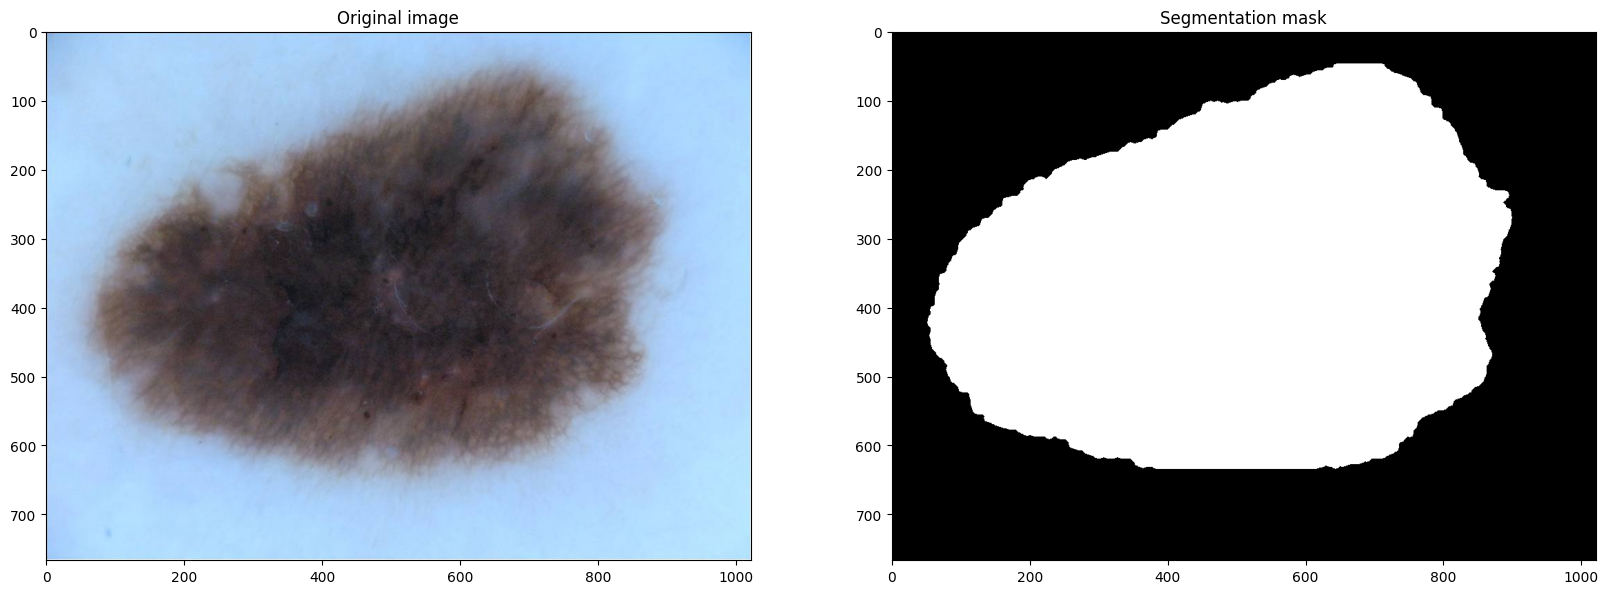

In [ ]:
# Read training images and get their shape
image_to_visualize = 0
img1 = imageio.imread(input_img_paths[image_to_visualize])
img_shape = np.shape(img1)
print(f"The shape of the pictures in the training set is: {img_shape}")

# Read target images and get their shape
img1 = imageio.imread(target_img_paths[image_to_visualize])
img_shape = np.shape(img1)
print(f"The shape of the pictures in the target set is: {img_shape}")

# Create figure
fig = plt.figure(figsize=(20, 20))

# Cetting values to rows and column variables
rows = 1
columns = 2

# Plot images - Visualize an image and it's segmentation
fig.add_subplot(rows, columns, 1)
plt.imshow(imageio.imread(input_img_paths[image_to_visualize]))
plt.title("Original image")

fig.add_subplot(rows, columns, 2)
plt.imshow(imageio.imread(target_img_paths[image_to_visualize]), cmap='gray')
plt.title("Segmentation mask")

In [ ]:
import numpy as np
import tensorflow as tf

class LesionSegmentation(tf.keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths, data_augmentation):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.data_augmentation = data_augmentation

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="float32")  # Change dtype to float32

        for j, path in enumerate(batch_input_img_paths):
            img = tf.keras.preprocessing.image.load_img(path, target_size=self.img_size)
            img = tf.keras.preprocessing.image.img_to_array(img)
            img = img / 255.0
            x[j] = img

            img_target = tf.keras.preprocessing.image.load_img(batch_target_img_paths[j], target_size=self.img_size, color_mode="grayscale")
            img_target = tf.keras.preprocessing.image.img_to_array(img_target)
            img_target = img_target / 255.0
            y[j] = img_target  # Assign directly without np.newaxis and np.squeeze

        if self.data_augmentation:
            augmented_x, augmented_y = [], []
            for img, mask in zip(x, y):
                # Rotate the image and mask
                rotated_img = tf.image.rot90(img, k=1)  # 90-degree rotation
                rotated_mask = tf.image.rot90(mask, k=1)  # 90-degree rotation

                augmented_x.append(rotated_img)
                augmented_y.append(rotated_mask)

            x.extend(augmented_x)
            y.extend(augmented_y)

        return np.array(x), np.array(y)


In [ ]:
# Split our img paths into a training validation and test sets
random.Random(2567).shuffle(input_img_paths)
random.Random(2567).shuffle(target_img_paths)

test_samples = int(len(input_img_paths)*percentage_test)
train_input_img_paths = input_img_paths[:-test_samples]
train_target_img_paths = target_img_paths[:-test_samples]
test_input_img_paths = input_img_paths[-test_samples:]
test_target_img_paths = target_img_paths[-test_samples:]

val_samples = int(len(train_input_img_paths)*percentage_validation)
val_input_img_paths = train_input_img_paths[-val_samples:]
val_target_img_paths = train_target_img_paths[-val_samples:]
train_input_img_paths = train_input_img_paths[:-val_samples]
train_target_img_paths = train_target_img_paths[:-val_samples]

print(f"Samples in train: {len(train_input_img_paths)}")
print(f"Samples in validation: {len(val_input_img_paths)}")
print(f"Samples in test: {len(test_input_img_paths)}")

Samples in train: 770
Samples in validation: 85
Samples in test: 45


In [ ]:
# Instantiate data Sequences for each split
train_gen = LesionSegmentation(batch_size, img_size, train_input_img_paths, train_target_img_paths, data_augmentation)
val_gen = LesionSegmentation(batch_size, img_size, val_input_img_paths, val_target_img_paths, False)

In [ ]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)

    return model

# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 80, 80, 32)           896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 80, 80, 32)           128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 80, 80, 32)           0         ['batch_normalization[0][0

In [ ]:
fit_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, epsilon=1e-8, amsgrad=True)

In [ ]:
%cd /content/

/content


In [ ]:

# Configure the model for training.
model.compile(optimizer=fit_optimizer, loss=loss_function)

# Safe best model
callbacks = [keras.callbacks.ModelCheckpoint("lesion_segmentaion.h5", save_best_only=True)]

# Train the model, doing validation at the end of each epoch.
model_history = model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

# Serialize and save model to json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)



Epoch 1/30
48/48 [==============================] - 41s 487ms/step - loss: 0.7030 - val_loss: 0.6438
Epoch 2/30
48/48 [==============================] - 23s 483ms/step - loss: 0.2619 - val_loss: 0.7687
Epoch 3/30
48/48 [==============================] - 23s 469ms/step - loss: 0.2283 - val_loss: 1.0723
Epoch 4/30
48/48 [==============================] - 23s 481ms/step - loss: 0.2069 - val_loss: 1.0742
Epoch 5/30
48/48 [==============================] - 23s 484ms/step - loss: 0.1871 - val_loss: 1.3031
Epoch 6/30
48/48 [==============================] - 23s 467ms/step - loss: 0.1762 - val_loss: 1.2473
Epoch 7/30
48/48 [==============================] - 23s 485ms/step - loss: 0.1663 - val_loss: 1.6459
Epoch 8/30
48/48 [==============================] - 23s 471ms/step - loss: 0.1608 - val_loss: 1.3247
Epoch 9/30
48/48 [==============================] - 23s 469ms/step - loss: 0.1421 - val_loss: 0.8347
Epoch 10/30
48/48 [==============================] - 23s 484ms/step - loss: 0.1267 - val_lo

In [ ]:
%cd /content/drive/MyDrive/

In [ ]:

# Serialize and save weights to HDF5
model.save_weights("segmentation_model.h5")
print("Saved model to disk")

Saved model to disk


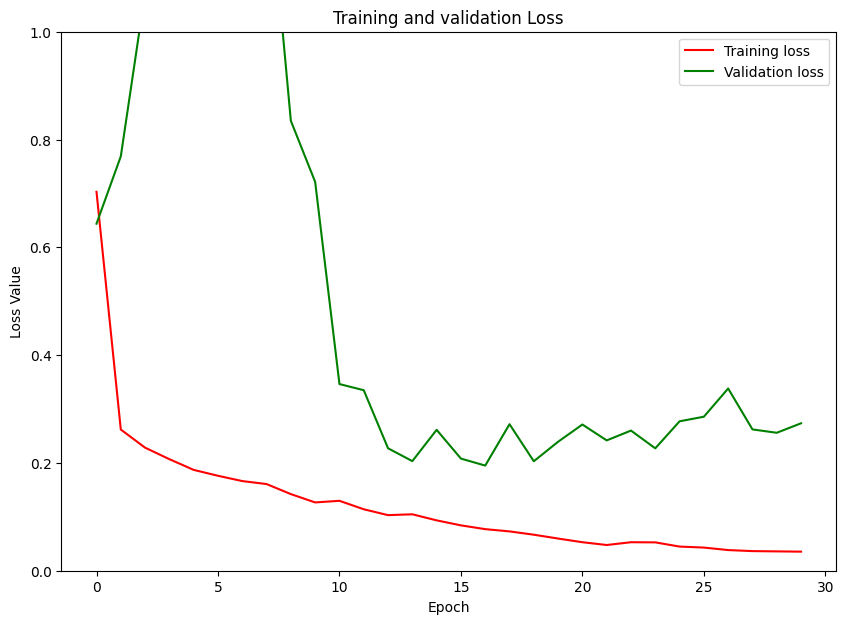

In [ ]:
# Plot training and validation loss while training
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure(figsize=(10, 7))
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'green', label='Validation loss')
plt.title('Training and validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.savefig('Training and validation loss.jpg', dpi=500)
plt.show()

In [ ]:
%cd /content/

/content


In [ ]:
from sklearn.metrics import mean_squared_error

test_gen = LesionSegmentation(batch_size, img_size, test_input_img_paths, test_target_img_paths, False)
test_preds = model.predict(test_gen)

jaccard_scores = []
dice_scores = []
pixel_accuracy = []
sensitivity = []
specificity = []
mse_scores = []

predictions_formatted = []
ground_truth_formatted = []

for i in range(len(test_preds)):
    # Adapt prediction and ground truth
    prediction = np.argmax(test_preds[i], axis=-1)
    prediction = np.expand_dims(prediction, axis=-1)
    predictions_formatted.append(prediction.flatten())
    ground_truth = np.array(load_img(test_target_img_paths[i], target_size=img_size, color_mode="grayscale"))
    ground_truth = (np.expand_dims(ground_truth, 2) / 255).astype(int)
    ground_truth_formatted.append(ground_truth.flatten())
    number_of_pixels = img_size[0] * img_size[1]

    # Get Jaccard score (Intersection over Union)
    intersection = np.logical_and(ground_truth, prediction)
    union = np.logical_or(ground_truth, prediction)
    jaccard_scores.append(np.sum(intersection) / np.sum(union))

    # Get Dice coefficient
    intersection = np.sum(ground_truth.flatten() == prediction.flatten())
    dice_scores.append((2 * np.sum(intersection)) / (number_of_pixels + number_of_pixels))

    # Compute MSE
    mse = mean_squared_error(ground_truth.flatten(), prediction.flatten())
    mse_scores.append(mse)

    # Pixel-based metrics
    equal_pixels = 0
    number_of_true_positives = 0
    number_of_true_negatives = 0
    number_of_false_negatives = 0
    number_of_false_positives = 0

    for row in range(len(ground_truth)):
        for column in range(len(ground_truth[row])):
            if prediction[row][column] == ground_truth[row][column]:
                equal_pixels += 1

            if ground_truth[row][column] == 1 and prediction[row][column] == ground_truth[row][column]:
                number_of_true_positives += 1

            if ground_truth[row][column] == 0 and prediction[row][column] == ground_truth[row][column]:
                number_of_true_negatives += 1

            if prediction[row][column] == 1 and prediction[row][column] != ground_truth[row][column]:
                number_of_false_positives += 1

            if prediction[row][column] == 0 and prediction[row][column] != ground_truth[row][column]:
                number_of_false_negatives += 1

    # Pixel accuracy: (Correct predictions / Number of predictions)
    pixel_accuracy.append(equal_pixels / number_of_pixels)

    # Sensitivity (Recall): True positive rate (True positives / True positives + False negatives)
    try:
        sensitivity.append(number_of_true_positives / (number_of_true_positives + number_of_false_negatives))
    except:
        sensitivity.append(0)

    # Specificity: True negative rate (True negatives / True negatives + False positives)
    try:
        specificity.append(number_of_true_negatives / (number_of_true_negatives + number_of_false_positives))
    except:
        specificity.append(0)

print(f"Jaccard Score (IoU): {np.mean(jaccard_scores)}")
print(f"Dice Score: {np.mean(dice_scores)}")
print(f"Pixel Accuracy: {np.mean(pixel_accuracy)}")
print(f"Sensitivity: {np.mean(sensitivity)}")
print(f"Specificity: {np.mean(specificity)}")
print(f"Mean Squared Error (MSE): {np.mean(mse_scores)}")


2/2 [==============================] - 1s 442ms/step
Jaccard Score (IoU): 0.8112987234110571
Dice Score: 0.9518115234375
Pixel Accuracy: 0.9518115234375
Sensitivity: 0.9144469884885549
Specificity: 0.9663833760005265
Mean Squared Error (MSE): 0.048188476562500006


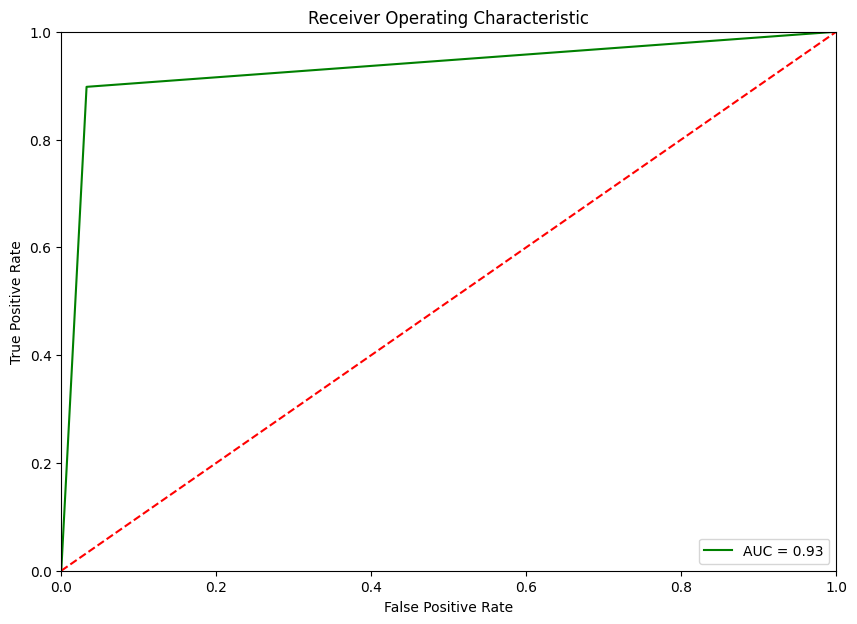

In [ ]:
# Get and plot ROC curve
fpr, tpr, threshold = metrics.roc_curve(np.array(predictions_formatted).flatten(), np.array(ground_truth_formatted).flatten())
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(10, 7))
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'green', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig('ROC_curve.jpg', dpi=500)
plt.show()

In [ ]:
def adapt_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(test_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    return img

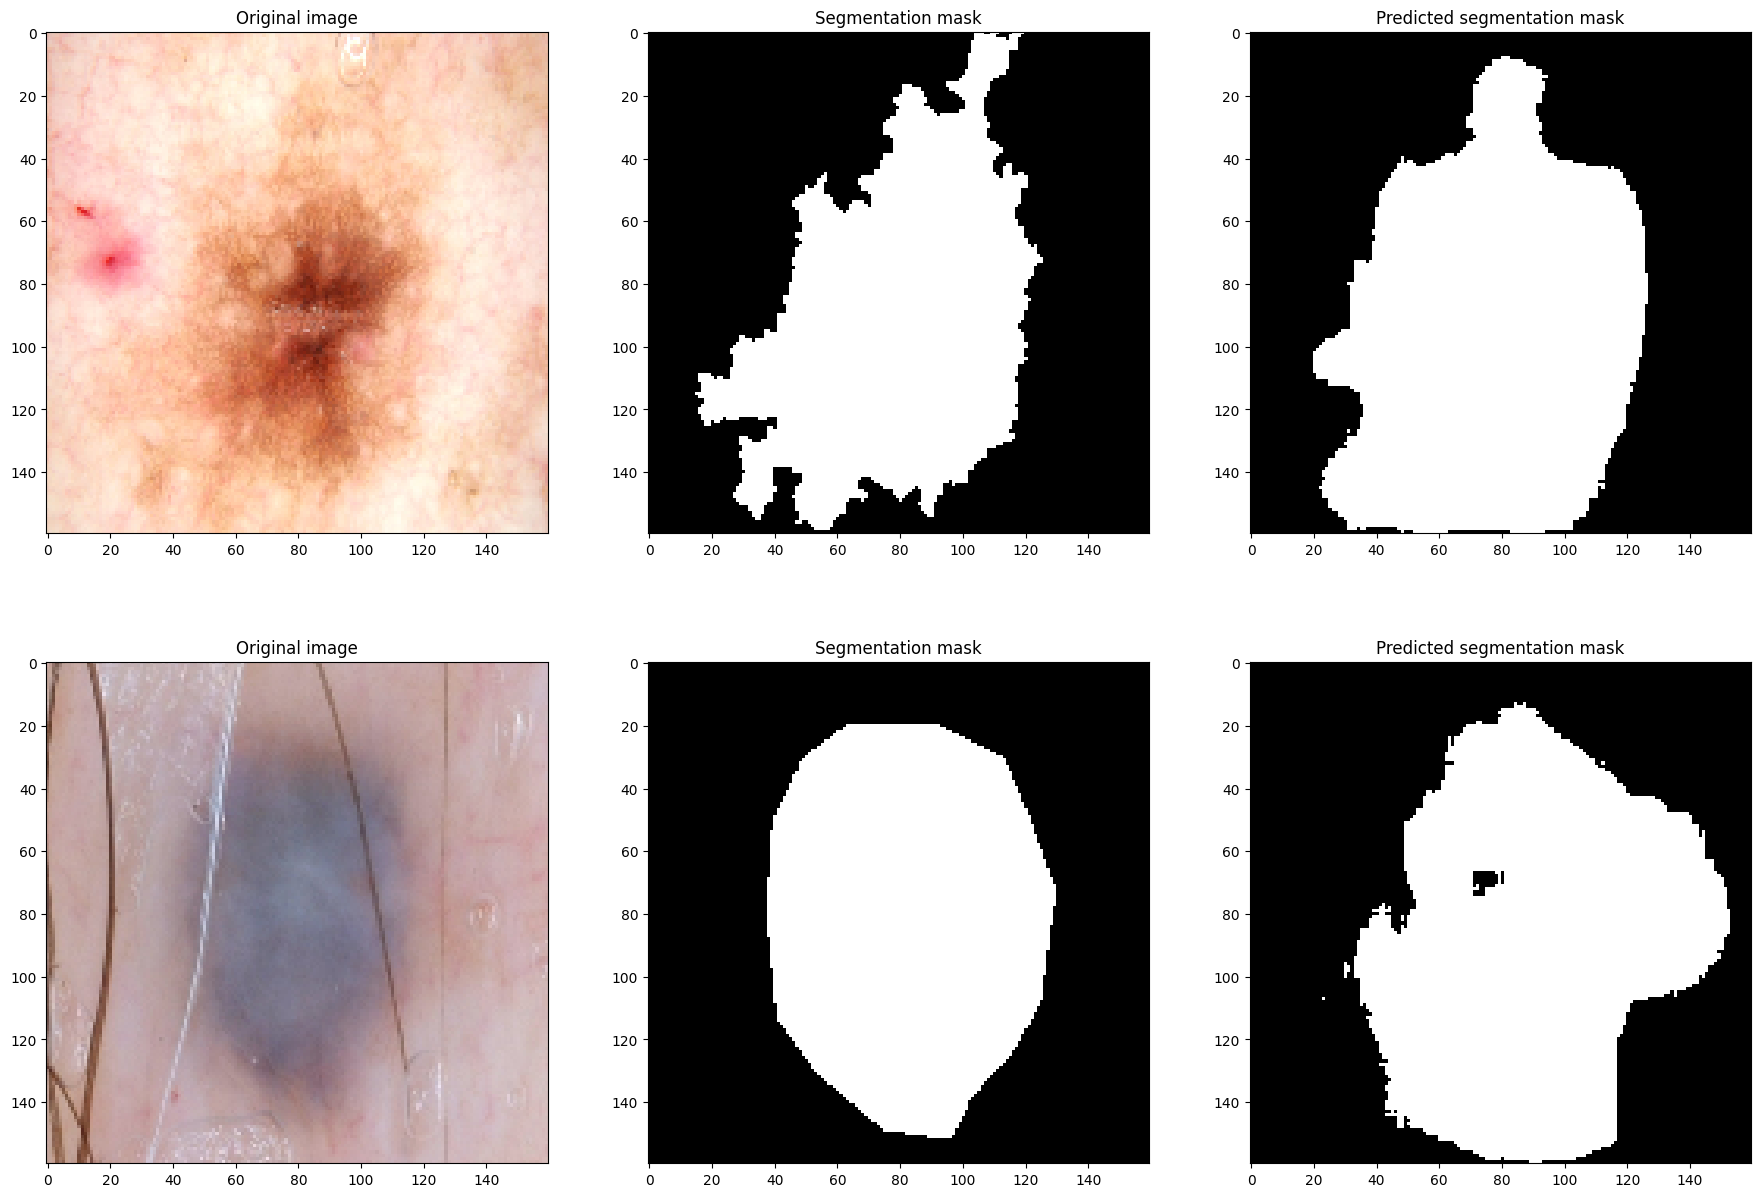

In [ ]:
# Cetting values to rows and column variables
rows = 2
columns = 3

# Create figure
fig, axs = plt.subplots(nrows=rows, ncols=columns, figsize=(22, 15))
row = 0

for i in [1, 5]:

    column = 0

    # Plot images
    axs[row, column].imshow(load_img(test_input_img_paths[i], target_size=img_size))
    axs[row, column].set_title("Original image")
    column+=1

    axs[row, column].imshow(load_img(test_target_img_paths[i],  target_size=img_size), cmap='gray')
    axs[row, column].set_title("Segmentation mask")
    column+=1

    axs[row, column].imshow(adapt_mask(i), cmap='gray')
    axs[row, column].set_title("Predicted segmentation mask")
    column+=1
    row+=1

plt.savefig('Predicted segmantation masks.jpg', dpi=300)